In [25]:
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.resnet import resnet101
from torch.utils.data import DataLoader, Dataset
import cv2
import torch.nn as nn
from gensim.models import KeyedVectors
from torchvision import transforms
from torch.nn import functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math


In [26]:

# Paths
DATASET_PATH = r"E:\My Research Project\CODE\DATA\Combined_Dataset"
SAFETY_RULES_PATH = r"E:\My Research Project\CODE\Saftey Rules-OG.txt"  # Safety rules file
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 19  # Adjust according to your dataset
print(f"Model Running on {DEVICE}")


Model Running on cuda


In [27]:
class CustomDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]
        self.label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_path, self.image_files[idx])
        label_path = os.path.join(self.labels_path, self.label_files[idx])
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        with open(label_path, "r") as f:
            labels = [list(map(float, line.strip().split())) for line in f]

        boxes = []
        classes = []
        for label in labels:
            class_id, x_center, y_center, width, height = label
            if width > 0 and height > 0:  # Check for valid bounding boxes
                xmin = x_center - width / 2
                ymin = y_center - height / 2
                xmax = x_center + width / 2
                ymax = y_center + height / 2
                boxes.append([xmin, ymin, xmax, ymax])
                classes.append(int(class_id))
        if len(boxes) == 0:  # Handle cases with no valid bounding boxes
            return self.__getitem__((idx + 1) % len(self))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        classes = torch.tensor(classes, dtype=torch.int64)
        target = {"boxes": boxes, "labels": classes}
        return image, target

In [28]:
def get_data_loader(dataset_path, mode, batch_size=2):
    images_path = os.path.join(dataset_path, mode, "images")
    labels_path = os.path.join(dataset_path, mode, "labels")
    dataset = CustomDataset(images_path, labels_path, transform=transforms.ToTensor())
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [29]:
def get_model(num_classes):
    backbone = resnet101(pretrained=False)
    backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove fully connected layers
    backbone.out_channels = 2048  # Output channels of ResNet-101

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    return model

In [30]:
# Text Embedding with GloVe
class TextEmbedding(nn.Module):
    def __init__(self, glove_file=r"E:\My Research Project\CODE\glove.6B.300d.txt", embedding_dim=300):
        super(TextEmbedding, self).__init__()
        print(f"Loading GloVe embeddings from {glove_file}...")
        self.glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)
        self.embedding_dim = embedding_dim
        self.fc = nn.Linear(embedding_dim, 128)

    def forward(self, text_input):
        embeddings = [self.glove_model[word] for word in text_input.split() if word in self.glove_model]
        embeddings = torch.tensor(embeddings, dtype=torch.float32)
        embeddings = embeddings.mean(dim=0)  # Average embeddings for input text
        return self.fc(embeddings.unsqueeze(0))

In [31]:
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.frcnn = get_model(num_classes)
        self.text_embedding = TextEmbedding()
        self.concat_fc = nn.Linear(2048 + 128, num_classes)

    def forward(self, images, targets=None, safety_text=None):
        if self.training:
            losses = self.frcnn(images, targets)
            return losses
        else:
            detections = self.frcnn(images)
            if safety_text is not None:
                text_features = self.text_embedding(safety_text)
                combined_features = torch.cat((detections["features"], text_features), dim=1)
                return self.concat_fc(combined_features)
            return detections

In [32]:

# Load Model from Checkpoint
def load_model_from_checkpoint(checkpoint_path, num_classes):
    model = CombinedModel(num_classes=num_classes).to(DEVICE)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state"])
    print("Model loaded successfully from checkpoint.")
    model.eval()
    return model


In [33]:
def test_model(model, data_loader, max_images=50):
    """
    Test the model and collect predictions and targets.
    """
    model.eval()
    predictions = []
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for idx, (images, targets) in enumerate(data_loader):
            if idx >= max_images:  # Limit to a maximum number of images
                break

            images = [img.to(DEVICE) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output.get("boxes", torch.empty(0)).cpu().numpy()
                pred_labels = output.get("labels", torch.empty(0)).cpu().numpy()
                true_boxes = targets[i]["boxes"].cpu().numpy()
                true_labels = targets[i]["labels"].cpu().numpy()

                # Align predictions and targets
                pred_labels = pred_labels[:len(true_labels)]  # Truncate predictions to match targets
                all_targets.extend(true_labels.tolist())
                all_preds.extend(pred_labels.tolist())

                # Append for visualization
                if len(predictions) < max_images:
                    predictions.append((images[i].cpu(), pred_boxes, pred_labels, true_boxes, true_labels))

    return predictions, all_targets, all_preds


In [67]:
import cv2
import os
import numpy as np

def visualize_predictions_with_opencv(predictions, label_names, save_dir="output_images"):
    """
    Visualize and save predictions using OpenCV for better alignment.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for idx, (image, pred_boxes, pred_labels, true_boxes, true_labels) in enumerate(predictions):
        # Convert the image tensor to a NumPy array
        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * 255).astype(np.uint8)  # Scale to 0-255
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

        img_height, img_width, _ = img_np.shape

        # Draw true bounding boxes (Green)
        for box, label in zip(true_boxes, true_labels):
            x_center, y_center, width, height = box
            xmin = int((x_center - width / 2) * img_width)
            ymin = int((y_center - height / 2) * img_height)
            xmax = int((x_center + width / 2) * img_width)
            ymax = int((y_center + height / 2) * img_height)
            label_name = label_names[label] if label < len(label_names) else "Unknown"
            cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # Green box
            cv2.putText(img_np, f"True: {label_name}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Draw predicted bounding boxes (Red)
        for box, label in zip(pred_boxes, pred_labels):
            x_center, y_center, width, height = box
            xmin = int((x_center - width / 2) * img_width)
            ymin = int((y_center - height / 2) * img_height)
            xmax = int((x_center + width / 2) * img_width)
            ymax = int((y_center + height / 2) * img_height)
            label_name = label_names[label] if label < len(label_names) else "Unknown"
            cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  # Red box
            cv2.putText(img_np, f"Pred: {label_name}", (xmin, ymax + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        # Save the image to a directory
        save_path = os.path.join(save_dir, f"image_{idx + 1}.jpg")
        cv2.imwrite(save_path, img_np)

        print(f"Saved image to {save_path}")


In [68]:
def evaluate_and_visualize_metrics(all_targets, all_preds):
    """
    Evaluate and visualize metrics (accuracy, precision, recall, F1 score).
    """
    # Ensure alignment of predictions and targets
    min_length = min(len(all_targets), len(all_preds))
    all_targets = all_targets[:min_length]
    all_preds = all_preds[:min_length]

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_targets, all_preds, average="weighted", zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot metrics
    metrics = {"Precision": precision, "Recall": recall, "F1 Score": f1}
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
    plt.title("Evaluation Metrics")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.show()


Loading GloVe embeddings from E:\My Research Project\CODE\glove.6B.300d.txt...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25588\1043328546.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model loaded successfully from checkpoint.
Saved image to output_images\image_1.jpg
Saved image to output_images\image_2.jpg
Saved image to output_images\image_3.jpg
Saved image to output_images\image_4.jpg
Saved image to output_images\image_5.jpg
Saved image to output_images\image_6.jpg
Saved image to output_images\image_7.jpg
Saved image to output_images\image_8.jpg
Saved image to output_images\image_9.jpg
Saved image to output_images\image_10.jpg
Accuracy: 0.2105
Precision: 0.0921
Recall: 0.2105
F1 Score: 0.1281


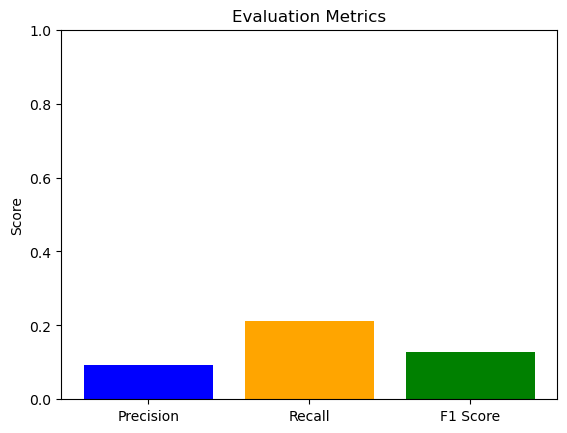

In [69]:

# Main Execution
if __name__ == "__main__":
    checkpoint_path = r"E:\My Research Project\CODE\model_checkpoint.pth"
    test_loader = get_data_loader(DATASET_PATH, "test", batch_size=1)

    # Load model from checkpoint
    model = load_model_from_checkpoint(checkpoint_path, NUM_CLASSES)

    # Test the model
    predictions, all_targets, all_preds = test_model(model, test_loader, max_images=10)

    # Visualize predictions
    labelnames =  ['EXCAVATORS', 'dump truck', 'wheel loader', 'Ladder', 'Person', 'Fall-Detected', 'Gloves', 'Goggles', 'Hardhat', 'Ladder', 'Mask', 'NO-Gloves', 'NO-Goggles', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest'] 
    visualize_predictions_with_opencv(predictions,labelnames)

    # Evaluate and visualize metrics
    evaluate_and_visualize_metrics(all_targets, all_preds)
